# About

These is a base solution of PID.

In [1]:
%matplotlib inline
import pandas
import numpy
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
import os

# Init params

In [2]:
track = 'Long'
particle = 'Ghost'

data_path = "data/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/\
GhostAccFrac1.0/TMVA-Run2-NoTkLikCD/" + track

work_path = "baseline/MC2015Sim09Dev03/TrainMixture/TrainPhysTks-EvalPhysTks-NoReweight/GhostAccFrac1.0/" + \
particle + "/" + track + "/PyROOT_TMVA/kMLP"

netconfig_path = "data/configs/networks/TMVA-Run2-NoTkLikCDVelodEdx/" + "GlobalPID_" \
+ particle + "_" + track + "_ANN.txt"

# if not os.path.exists(work_path):
#     os.makedirs(work_path)
# os.chdir(work_path)

In [3]:
pwd

u'/Users/mikhail91/Documents/Github/PID/mikhail_hushchyn'

In [4]:
particle_pdg_codes = {"all": 999999,
                    "Ghost": 0,
                    "Electron": 11,
                    "Muon": 13,
                    "Pion": 211,
                    "Kaon": 321,
                    "Proton": 2212}

pdg = particle_pdg_codes[particle]

In [5]:
netconfig = numpy.loadtxt(netconfig_path, dtype='S', delimiter='\n', comments='!')
features = []
spectator_features = []

for var in netconfig[5:]:
    
    if var.find('#') == -1:
        features.append(var)
    else:
        spectator_features.append(var[1:])

In [6]:
print "dfwefwefwef = %d" % pdg

dfwefwefwef = 0


# Read data

In [7]:
import ROOT
f = ROOT.TFile(data_path +'/data_train.root')
ntuple = f.Get('tree')

In [8]:
import root_numpy
p_type = root_numpy.root2array(data_path +'/data_train.root', treename='tree', branches=['MCParticleType'])
p_type = numpy.asarray(p_type, dtype=float)
p_type = numpy.abs(p_type)

nTest_Signal = int(0.3 * (p_type == pdg).sum())
nTest_Bkg = int(0.3 * (p_type != pdg).sum())

print nTest_Signal, nTest_Bkg

50887 309112


# Train TMVA MLP

In [9]:
import ROOT
ROOT.TMVA.Tools.Instance()
fout = ROOT.TFile(work_path + "/test.root","RECREATE")

factory = ROOT.TMVA.Factory("TMVAClassification", fout,
                            ":".join([
                                "!V",
                                "!Silent",
                                "Color",
                                "DrawProgressBar",
                                "Transformations=I",#;D;P;G,D
                                "AnalysisType=Classification"]
                                     ))

for i in range(0, len(features)):
    factory.AddVariable(features[i],"F")
#factory.AddVariable("TrackPt","F")



factory.AddSignalTree(ntuple)
factory.AddBackgroundTree(ntuple)
 
# cuts defining the signal and background sample
sigCut = ROOT.TCut("abs(MCParticleType) == %d" % pdg)
bgCut = ROOT.TCut("abs(MCParticleType) != %d" % pdg)
 
factory.PrepareTrainingAndTestTree(sigCut,   # signal events
                                   bgCut,    # background events
                                   ":".join([
                                        "nTrain_Signal=0",
                                        "nTrain_Background=0",
                                        "nTest_Signal=%d" % nTest_Signal,
                                        "nTest_Background=%d" % nTest_Bkg,
                                        "SplitMode=Random",
                                        "NormMode=None",
                                        "SplitSeed=42"
                                        "!V"
                                       ]))

In [10]:
N = int(1.4 * len(features))
print "adwedwe %d" % N

adwedwe 44


In [ ]:
%%time

method = factory.BookMethod(ROOT.TMVA.Types.kMLP, "MLP",
                   ":".join([
                       "H",
                       "V",
                       "NCycles=750",
                       "HiddenLayers=%d" % N,
                       "EpochMonitoring=true",
                       "UseRegulator=true",
                       "ConvergenceImprove=1e-16",
                       "ConvergenceTests=15",
                       "VarTransform=Norm",
                       "NeuronType=sigmoid",
                        "TrainingMethod=BP",
                        "EstimatorType=CE"
                       ]))
 
factory.TrainAllMethods()
factory.TestAllMethods()
factory.EvaluateAllMethods()

# Evaluation

In [7]:
import ROOT
reader = ROOT.TMVA.Reader()
import array

L = []

for i in range(0, len(features)):
    var = array.array('f',[0])
    reader.AddVariable(features[i],var)
    L.append(var)

reader.BookMVA("MLP",work_path + "/weights/TMVAClassification_MLP.weights.xml")




filename = data_path + "/data_eval.csv"
data_eval = pandas.read_csv(filename)

labels_eval = (numpy.abs(data_eval.MCParticleType.values) == pdg) * 1.


test = numpy.array(data_eval[features+['MCParticleType']].values.tolist())

In [8]:
probas = []
for i in range(0, len(test)):
    for k in range(0, len(L)):
        L[k][0] = test[i,:][k]
    probas.append(reader.EvaluateMVA("MLP"))


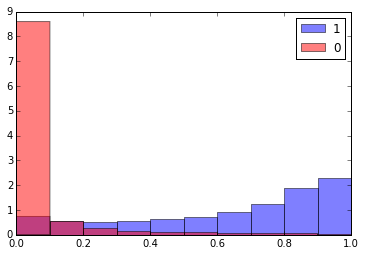

In [9]:
probas = numpy.array(probas)
plt.hist(probas[labels_eval==1], color='b', alpha=0.5, label='1', normed=True)
plt.hist(probas[labels_eval==0], color='r', alpha=0.5, label='0', normed=True)
plt.legend(loc='best')
plt.show()

In [10]:
roc_auc = roc_auc_score(labels_eval, probas)
print roc_auc

0.957517533552


In [11]:
import os, sys
sys.path.append('src')

from get_figures import all_figures

params = {}
params['PARTICLE'] = particle
params['TRACK'] = track

eval_proba = numpy.concatenate(((1 - probas).reshape(-1, 1), probas.reshape(-1, 1)), axis=1)
eval_proba

array([[  9.99374568e-01,   6.25431976e-04],
       [  9.93025549e-01,   6.97445082e-03],
       [  9.98772506e-01,   1.22749352e-03],
       ..., 
       [  4.32194948e-01,   5.67805052e-01],
       [  9.92093525e-01,   7.90647463e-03],
       [  9.51935584e-01,   4.80644156e-02]])

In [12]:
%%time
all_figures(params, data_eval, eval_proba, labels_eval, features, path= work_path + "/pic")

CPU times: user 10min 33s, sys: 2min 11s, total: 12min 45s
Wall time: 12min 55s


1